Columns with only missing values: ['local_orig']
detailed-label
C&C                          6706
DDoS                         5757
-                            1923
PartOfAHorizontalPortScan     122
Name: count, dtype: int64
label
Malicious    3860
Benign       1923
Name: count, dtype: int64
detailed-label
C&C                          2023
-                            1923
DDoS                         1715
PartOfAHorizontalPortScan     122
Name: count, dtype: int64


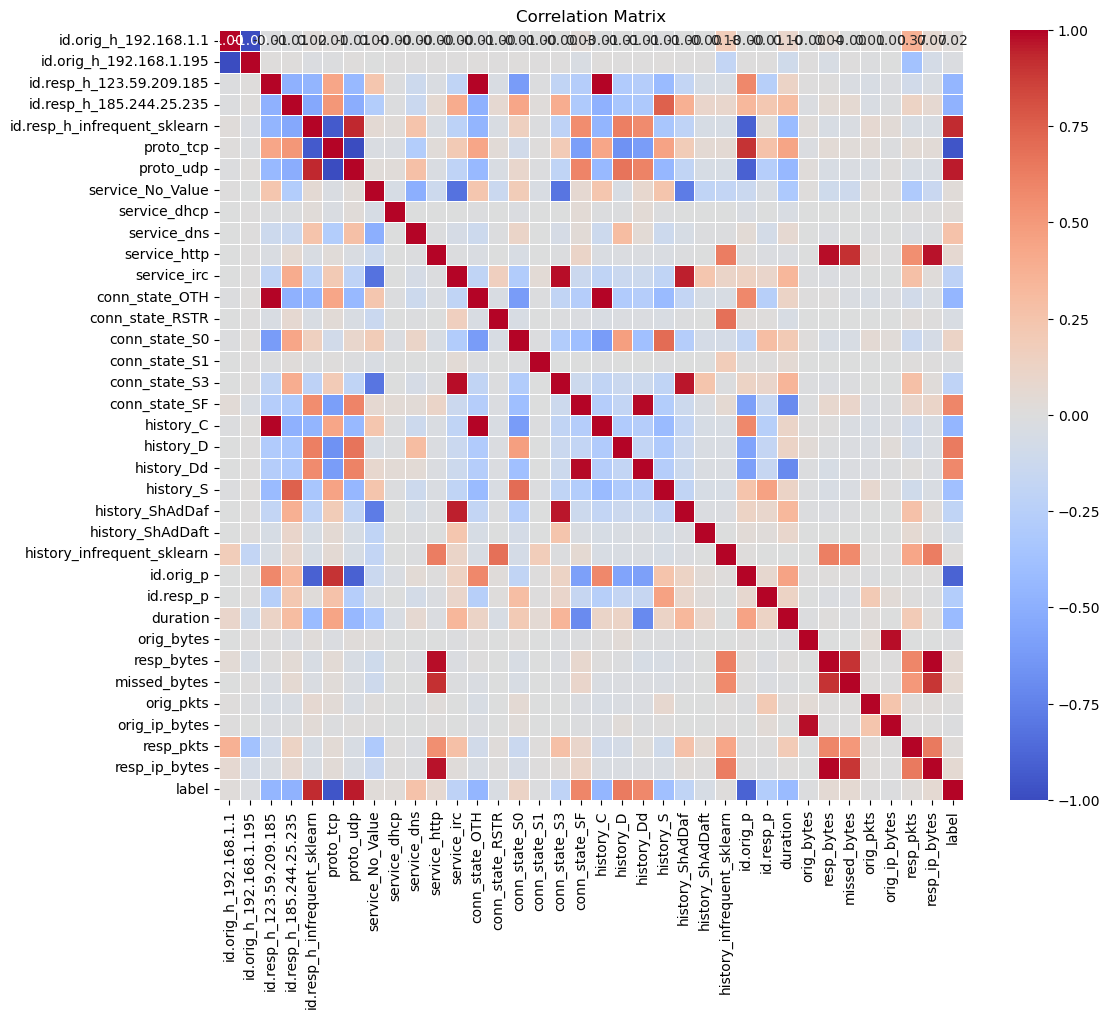

In [176]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Define the file path
file_path = 'conn.log.labeled'

# Manually define the expected column names
column_names = [
    "ts", "uid", "id.orig_h", "id.orig_p", "id.resp_h", "id.resp_p", "proto",
    "service", "duration", "orig_bytes", "resp_bytes", "conn_state",
    "local_orig", "local_resp", "missed_bytes", "history", "orig_pkts",
    "orig_ip_bytes", "resp_pkts", "resp_ip_bytes", "tunnel_parents"
]

# Read the file
df = pd.read_csv(
    file_path,
    sep="\t",  # Separator is tab
    comment="#",  # Skip lines starting with '#'
    header=None,  # No header in data section
    skip_blank_lines=True  # Avoid blank lines
)

# Add placeholder columns if fewer than expected
while df.shape[1] < len(column_names):
    df[df.shape[1]] = "-"

# Assign column names
df.columns = column_names

# Replace `-` with NaN for better handling of missing data
df.replace("-", pd.NA, inplace=True)

# Check which columns have only NaN values
all_na_columns = df.columns[df.isna().all()].tolist()
print(f"Columns with only missing values: {all_na_columns}")

# Optionally drop columns with only NaN
df.drop(columns=all_na_columns, inplace=True)

# Handle 'tunnel_parents' column to split space-separated values
df[['tunnel_parents', 'label', 'detailed-label']] = df['tunnel_parents'].str.split(r'\s+', n=2, expand=True)

# Contar a quantidade de cada tipo de 'detailed-label'
detailed_label_counts = df['detailed-label'].value_counts()

# Verificar a quantidade da classe majoritária (DDoS)
ddos_count = detailed_label_counts['DDoS']

# Verificar a quantidade de dados da classe minoritária
minority_class_size = len(df[df['detailed-label'] != 'DDoS'])

# Definir o percentual de redução da classe DDoS
percentage_reduction = 0.6 # Exemplo: reduzir 60% da classe DDoS

# Calcular o número de amostras a serem mantidas na classe DDoS
ddos_undersample_size = int(ddos_count * (1 - percentage_reduction))

# Realizar undersampling na classe DDoS para a quantidade calculada
df_ddos_undersampled = df[df['detailed-label'] == 'DDoS'].sample(ddos_undersample_size, random_state=42)

# Manter a parte dos dados que não são DDoS
df_other = df[df['detailed-label'] != 'DDoS']

# Concatenar as duas partes balanceadas
df_balanced = pd.concat([df_ddos_undersampled, df_other])

# Embaralhar o DataFrame final para aleatorizar os dados
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Exibir a nova distribuição
print(df_balanced['detailed-label'].value_counts())

# Contar a quantidade de cada tipo de 'label'
detailed_label_counts = df_balanced['label'].value_counts()

# Verificar a quantidade da classe majoritária (Malicious)
malicious_count = detailed_label_counts['Malicious']

# Verificar a quantidade de dados da classe minoritária (Benign)
benign_count = detailed_label_counts['Benign']

# Definir o percentual de redução da classe Malicious
percentage_reduction_malicious = 0.7  # Exemplo: reduzir 70% da classe Malicious

# Dividir os dados da classe Malicious em duas partes:
# 1. Parte com detailed_label = 'PartOfAHorizontalPortScan'
df_malicious_partscan = df_balanced[(df_balanced['label'] == 'Malicious') & 
                                    (df_balanced['detailed-label'] == 'PartOfAHorizontalPortScan')]

# 2. Parte restante da classe Malicious (sem 'PartOfAHorizontalPortScan')
df_malicious_others = df_balanced[(df_balanced['label'] == 'Malicious') & 
                                   (df_balanced['detailed-label'] != 'PartOfAHorizontalPortScan')]

# Calcular o número de amostras a serem mantidas na parte restante da classe Malicious
malicious_undersample_size = int(df_malicious_others.shape[0] * (1 - percentage_reduction_malicious))

# Realizar undersampling na parte restante da classe Malicious
df_malicious_undersampled = df_malicious_others.sample(malicious_undersample_size, random_state=42)

# Manter a parte dos dados que não são Malicious
df_other = df_balanced[df_balanced['label'] != 'Malicious']

# Concatenar a parte não alterada de 'PartOfAHorizontalPortScan', 
# a parte reduzida de Malicious e os dados de outras classes
df_balanced = pd.concat([df_malicious_partscan, df_malicious_undersampled, df_other])

# Embaralhar o DataFrame final para aleatorizar os dados
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Exibir a nova distribuição
print(df_balanced['label'].value_counts())

# Mostrar gráficos novamente para verificar a distribuição balanceada
detailed_label_counts_balanced = df_balanced['label'].value_counts()
print(df_balanced['detailed-label'].value_counts())

df_balanced.drop(columns=['ts','uid','detailed-label','tunnel_parents'], inplace=True)

df_balanced['label'] = df_balanced['label'].replace({'Malicious': 0, 'Benign': 1})






# Replace <NA> with np.nan in 'duration' column
df_balanced['duration'] = df_balanced['duration'].replace({pd.NA: np.nan})

# Step 1: Impute missing values in the 'duration' column (impute before transformation)
imputer = SimpleImputer(strategy='median')
df_balanced['duration'] = imputer.fit_transform(df_balanced[['duration']])

# Step 2: Apply the log transformation to the 'duration' column
df_balanced['duration'] = df_balanced['duration'].apply(lambda x: np.log(x + 1) if x > 0 else 0)

# Step 3: Standardize the 'duration' column
scaler = StandardScaler()
df_balanced['duration'] = scaler.fit_transform(df_balanced[['duration']])





columns_to_encode = ['id.orig_h', 'id.resp_h', 'proto', 'service', 'conn_state', 'history']

# Substitui valores NA por 'No_Value'
df_balanced[columns_to_encode] = df_balanced[columns_to_encode].replace({pd.NA: 'No_Value'})

# Inicializa um DataFrame para os dados codificados
encoded_columns_df = pd.DataFrame()

for column in columns_to_encode:
    if column == 'id.resp_h':
        # Usa OneHotEncoder com max_categories=3 para 'id.resp_h'
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', max_categories=3)
    else:
        # Usa o OneHotEncoder padrão para outras colunas
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', max_categories=7)
    
    # Aplica o encoder na coluna
    encoded_column = encoder.fit_transform(df_balanced[[column]])
    
    # Converte a coluna codificada para DataFrame
    encoded_df = pd.DataFrame(
        encoded_column, 
        columns=encoder.get_feature_names_out([column])
    )
    
    # Concatena com o DataFrame de dados codificados
    encoded_columns_df = pd.concat([encoded_columns_df, encoded_df], axis=1)

# Concatena as colunas codificadas no DataFrame original
df_balanced_encoded = pd.concat([encoded_columns_df, df_balanced], axis=1)

# Remove as colunas originais
df_balanced_encoded.drop(columns=columns_to_encode, inplace=True)







# Ensure columns are numeric before filling NaNs
df_balanced_encoded['orig_bytes'] = pd.to_numeric(df_balanced_encoded['orig_bytes'], errors='coerce')
df_balanced_encoded['resp_bytes'] = pd.to_numeric(df_balanced_encoded['resp_bytes'], errors='coerce')

# Fill missing values with mean for numeric columns (assigning back to the column)
df_balanced_encoded['orig_bytes'] = df_balanced_encoded['orig_bytes'].fillna(df_balanced_encoded['orig_bytes'].mean())
df_balanced_encoded['resp_bytes'] = df_balanced_encoded['resp_bytes'].fillna(df_balanced_encoded['resp_bytes'].mean())

# For categorical columns, use the mode instead (assigning back to the column)
df_balanced_encoded['local_resp'] = df_balanced_encoded['local_resp'].fillna(df_balanced_encoded['local_resp'].mode()[0])
df_balanced_encoded['label'] = df_balanced_encoded['label'].fillna(df_balanced_encoded['label'].mode()[0])

# Calculate the mode of the 'missed_bytes' column
mode_value = df_balanced_encoded['missed_bytes'].mode()[0]

# Replace 'C' with the mode value
df_balanced_encoded['missed_bytes'] = df_balanced_encoded['missed_bytes'].replace('C', mode_value)


#Remove row with column "resp_ip_bytes" = "-   Malicious   DDoS"
df_balanced_encoded = df_balanced_encoded[df_balanced_encoded['resp_ip_bytes'] != '-   Malicious   DDoS']

#remove columns all zero columns
columns_to_remove = [col for col in df_balanced_encoded.columns if df_balanced_encoded[col].nunique() <= 1]
df_balanced_encoded = df_balanced_encoded.drop(columns=columns_to_remove)





# Now, calculate the correlation matrix again
correlation_matrix = df_balanced_encoded.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()



In [177]:
train_df, test_df = train_test_split(df_balanced_encoded, test_size=0.9, random_state=42)

# Check the distribution in train and test sets
print("Training set distribution:")
print(train_df['label'].value_counts())

print("\nTesting set distribution:")
print(test_df['label'].value_counts())

# Save the test DataFrame to a CSV file
train_df.to_csv('train_data.csv', index=False)
print("Train data saved to 'train_data.csv'.")

test_df.to_csv('test_data.csv', index=False)
print("Test data saved to 'test_data.csv'.")


#Print the name of the columns
print(train_df.columns)

Training set distribution:
label
0.0    396
1.0    182
Name: count, dtype: int64

Testing set distribution:
label
0.0    3464
1.0    1741
Name: count, dtype: int64
Train data saved to 'train_data.csv'.
Test data saved to 'test_data.csv'.
Index(['id.orig_h_192.168.1.1', 'id.orig_h_192.168.1.195',
       'id.resp_h_123.59.209.185', 'id.resp_h_185.244.25.235',
       'id.resp_h_infrequent_sklearn', 'proto_tcp', 'proto_udp',
       'service_No_Value', 'service_dhcp', 'service_dns', 'service_http',
       'service_irc', 'conn_state_OTH', 'conn_state_RSTR', 'conn_state_S0',
       'conn_state_S1', 'conn_state_S3', 'conn_state_SF', 'history_C',
       'history_D', 'history_Dd', 'history_S', 'history_ShAdDaf',
       'history_ShAdDaft', 'history_infrequent_sklearn', 'id.orig_p',
       'id.resp_p', 'duration', 'orig_bytes', 'resp_bytes', 'missed_bytes',
       'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'label'],
      dtype='object')


In [178]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Separate features (X) and labels (y) for training and testing sets
X_train = train_df.drop(columns=['label'])
y_train = train_df['label']

X_test = test_df.drop(columns=['label'])
y_test = test_df['label']

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=2, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Model Performance on Test Data:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Optionally, display feature importance
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

Model Performance on Test Data:
Accuracy: 0.978866474543708

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      3464
         1.0       0.99      0.95      0.97      1741

    accuracy                           0.98      5205
   macro avg       0.98      0.97      0.98      5205
weighted avg       0.98      0.98      0.98      5205


Feature Importances:
                         Feature  Importance
19                     history_D    0.511754
20                    history_Dd    0.231118
27                      duration    0.179162
25                     id.orig_p    0.028198
32                 orig_ip_bytes    0.022164
26                     id.resp_p    0.010395
4   id.resp_h_infrequent_sklearn    0.008957
34                 resp_ip_bytes    0.003988
14                 conn_state_S0    0.003917
2       id.resp_h_123.59.209.185    0.000339
3       id.resp_h_185.244.25.235    0.000008
30                  missed_

Confusion Matrix Values:
[[3439   25]
 [  85 1656]]


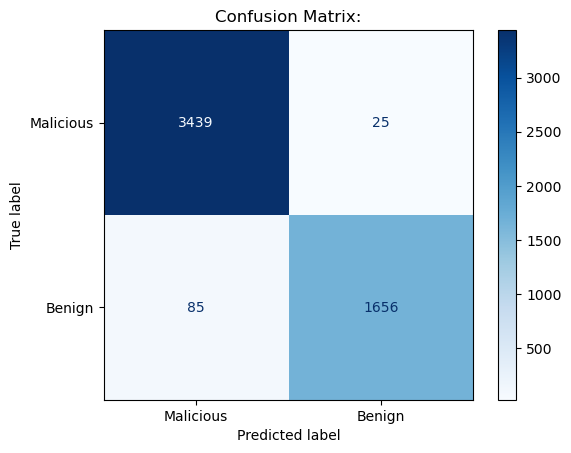

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Supondo que você tenha o modelo treinado (rf_model)
# Gerar previsões para o conjunto de teste
y_pred = rf_model.predict(X_test)

# Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
# Imprimir os valores da matriz de confusão
print("Confusion Matrix Values:")
print(cm)
    
    # Display confusion matrix using sklearn's ConfusionMatrixDisplay
    
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Malicious', 'Benign'])
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix:')
plt.show()


Logistic Regression Performance:
Accuracy: 0.8142
Confusion Matrix Values:
[[3463    1]
 [ 966  775]]


/home/diogo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


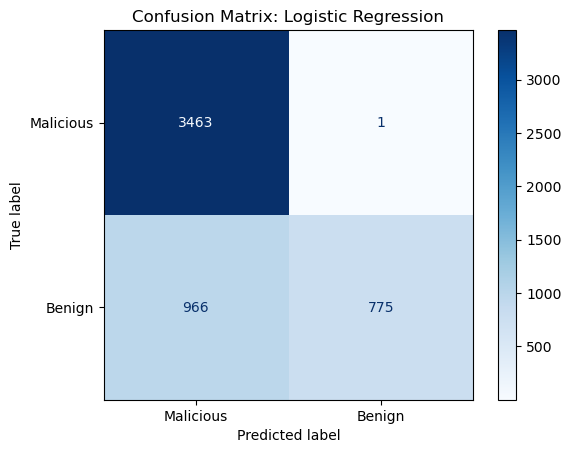


Decision Tree Performance:
Accuracy: 1.0000
Confusion Matrix Values:
[[3464    0]
 [   0 1741]]


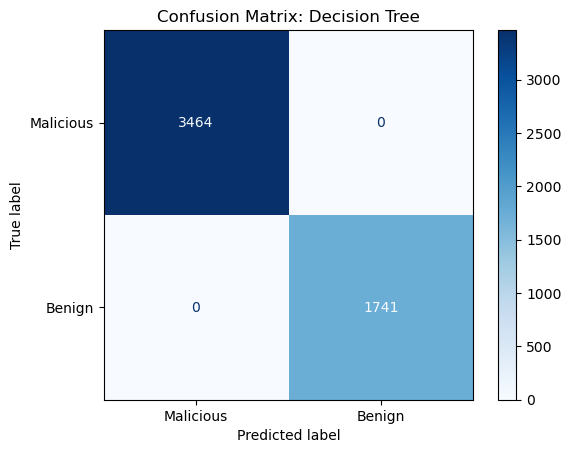


SVM Performance:
Accuracy: 0.9504
Confusion Matrix Values:
[[3453   11]
 [ 247 1494]]


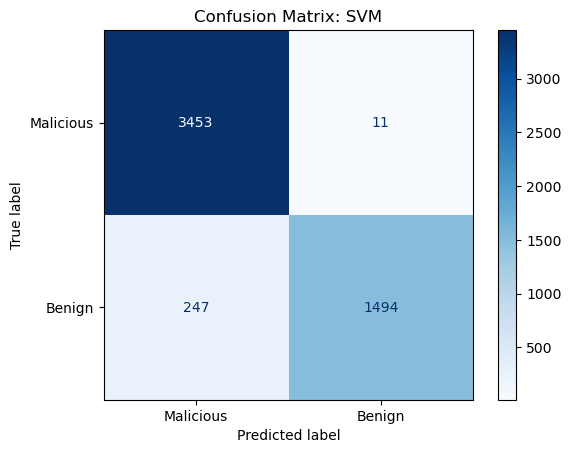


KNN Performance:
Accuracy: 0.9942
Confusion Matrix Values:
[[3449   15]
 [  15 1726]]


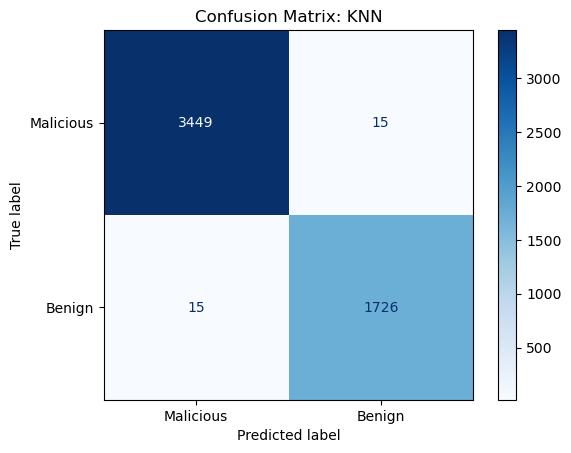


Random Forest Performance:
Accuracy: 0.9944
Confusion Matrix Values:
[[3460    4]
 [  25 1716]]


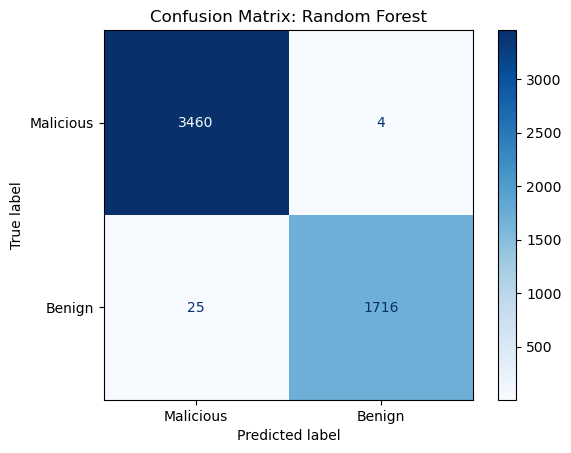


Gradient Boosting Performance:
Accuracy: 0.9900
Confusion Matrix Values:
[[3464    0]
 [  52 1689]]


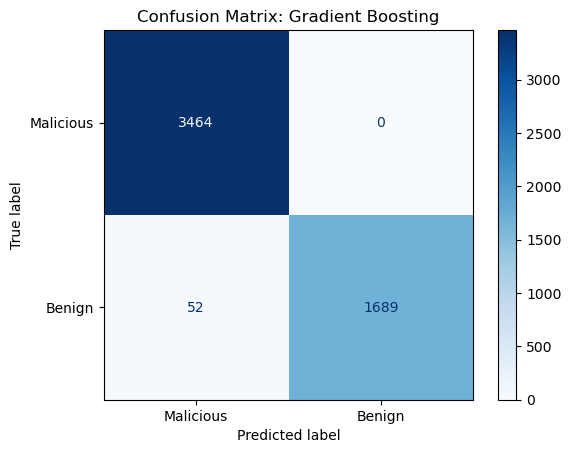


AdaBoost Performance:
Accuracy: 0.9879
Confusion Matrix Values:
[[3464    0]
 [  63 1678]]


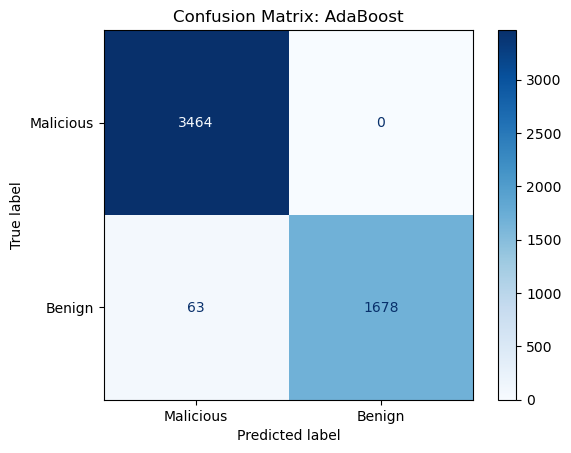

In [180]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


# Definir os modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=10),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=3),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=3),
    'AdaBoost': AdaBoostClassifier(n_estimators=3)
}

# Treinar e avaliar cada modelo
for model_name, model in models.items():
    # Treinar o modelo
    model.fit(X_train, y_train)
    
    # Previsões no conjunto de teste
    y_pred = model.predict(X_test)
    
    # Acurácia do modelo
    accuracy = accuracy_score(y_test, y_pred)
    
    # Exibir o relatório de classificação
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    
    
    # Gerar a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    # Imprimir os valores da matriz de confusão
    print("Confusion Matrix Values:")
    print(cm)
    
    # Display confusion matrix using sklearn's ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Malicious', 'Benign'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()